# Microbiome IBD Dysbiosis Pipeline

This robust notebook analyzes 16S rRNA gut microbiome data to classify samples into Crohn's Disease (CD), Ulcerative Colitis (UC), or Healthy Controls (non-IBD). 

**Key Aspects:**
1. **Taxonomic Preprocessing:** Aggregating OTUs to the Genus level.
2. **Microbiome Metrics:** Centered Log-Ratio (CLR) transformation addressing compositional constraints.
3. **Alpha & Beta Diversity:** Shannon index (with Kruskal-Wallis & Dunn's post-hoc) and explicit Bray-Curtis PCoA mapping (with PERMANOVA stats).
4. **Machine Learning & Valuation:** 5-fold CV, multimonial model comparisons (RF vs Logistic Regression), and robust Multi-Class ROC Curves.
5. **Feature Dysbiosis Analysis:** Permutation importance vs Gini impurity, mapping top taxa biology and mean abundance fold-shifts.

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stats and ML
import scipy.stats as stats
import scikit_posthocs as sp
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, roc_auc_score, f1_score, accuracy_score)
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

# Style parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (8, 6)})
sns.set_theme(style="whitegrid")
GLOBAL_PALETTE = {'non-IBD': '#2ECC71', 'CD': '#FC4349', 'UC': '#3498DB'} # High contrast accessible

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)

## 1. Prepare Metadata and OTU Dimensions

In [2]:
metadata = pd.read_csv('datasets/metadata.csv')
metadata['External ID'] = pd.to_numeric(metadata['External ID'], errors='coerce')
metadata = metadata.dropna(subset=['External ID', 'diagnosis'])
metadata['External ID'] = metadata['External ID'].astype(int)

# String standardization
def map_diagnosis(diag):
    diag_str = str(diag).strip()
    if 'non' in diag_str.lower(): return 'non-IBD'
    return diag_str

metadata['diagnosis'] = metadata['diagnosis'].apply(map_diagnosis)

otu_df = pd.read_csv('datasets/OTU.tsv', sep='\t').rename(columns={'#OTU ID': 'OTU_ID'})

taxonomy = otu_df[['OTU_ID', 'taxonomy']].copy()
otu_counts = otu_df.drop(columns=['taxonomy']).set_index('OTU_ID')
otu_counts_t = otu_counts.T
otu_counts_t.index = pd.to_numeric(otu_counts_t.index, errors='coerce')

df_merged = metadata.merge(otu_counts_t, left_on='External ID', right_index=True, how='inner')
print(f"Data joined. Valid dimensions: {df_merged.shape[0]} aligned samples.")

X_raw = df_merged[otu_counts_t.columns]

def extract_genus(tax_str):
    parts = tax_str.split(';')
    for part in parts:
        if '__' in part:
            rank, name = part.strip().split('__')
            if rank == 'g': return name
    return tax_str.split(';')[-1].strip()

taxonomy['Genus'] = taxonomy['taxonomy'].apply(extract_genus)
X_mapped = X_raw.T.copy()
X_mapped['Genus'] = taxonomy.set_index('OTU_ID').loc[X_mapped.index, 'Genus'].values
X_genus = X_mapped.groupby('Genus').sum().T

# 10% Prevalence Filtering
prevalence = (X_genus > 0).mean(axis=0)
X_genus_filtered = X_genus.loc[:, prevalence >= 0.1]
print(f"Taxonomy aggregated. {X_genus_filtered.shape[1]} viable Genera retained.")


Data joined. Valid dimensions: 163 aligned samples.
Taxonomy aggregated. 122 viable Genera retained.


## 2. Robust Microbiome Transformations (CLR & Relative)
Compositional data mathematically requires relative framing or geometry preserving transforms (e.g. Centered Log-Ratio) before ML mapping.

In [3]:
row_sums = X_genus_filtered.sum(axis=1)
row_sums[row_sums == 0] = 1 
X_rel = X_genus_filtered.div(row_sums, axis=0)

# CLR Transform
pseudo_count = X_rel[X_rel > 0].min().min() / 2
X_clr = np.log(X_rel + pseudo_count)
X_clr = X_clr.sub(X_clr.mean(axis=1), axis=0)

df_clinical = df_merged[['External ID', 'Participant ID', 'diagnosis']].copy()

# Export for R validation module
X_rel.to_csv('outputs/results/X_rel_abundance.csv')
df_clinical.to_csv('outputs/results/clinical_metadata.csv')


## 3. Alpha Diversity Analysis
Measuring intra-sample species richness and ecosystem evenness. We integrate Kruskal-Wallis statistical testing and post-hoc Dunn pairwise adjustments evaluating structural collapses in IBD ecosystems.

Global Kruskal-Wallis test p-value: 1.0015e-01


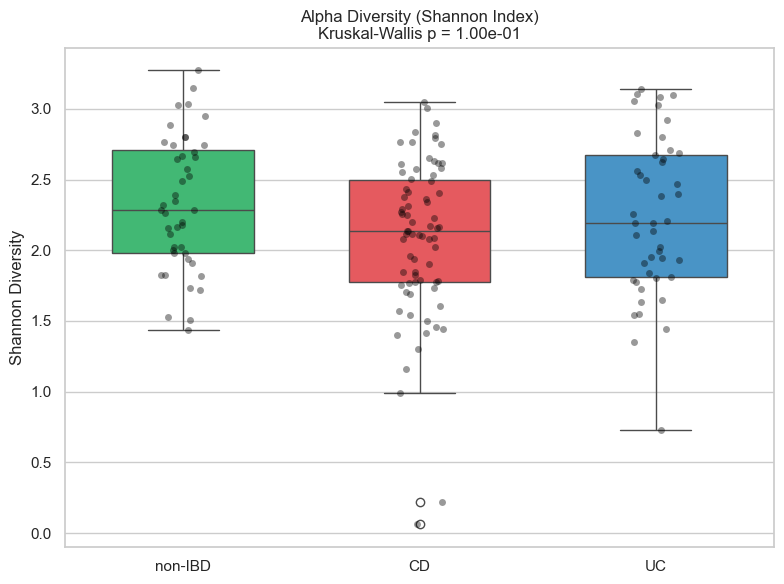

In [4]:
def shannon_index(row):
    p = row[row > 0]
    return -np.sum(p * np.log(p))

df_clinical['Shannon_Diversity'] = X_rel.apply(shannon_index, axis=1)

# Statistical Testing
groups = [df_clinical[df_clinical['diagnosis'] == g]['Shannon_Diversity'].values 
          for g in ['non-IBD', 'CD', 'UC']]
kw_stat, kw_p = stats.kruskal(*groups)
print(f"Global Kruskal-Wallis test p-value: {kw_p:.4e}")

if kw_p < 0.05:
    dunn_df = sp.posthoc_dunn(df_clinical, val_col='Shannon_Diversity', group_col='diagnosis', p_adjust='fdr_bh')
    print("\nDunn's Post-Hoc Test (FDR adjusted p-values):")
    print(dunn_df)

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='diagnosis', y='Shannon_Diversity', data=df_clinical, 
            order=['non-IBD', 'CD', 'UC'], palette=GLOBAL_PALETTE, ax=ax, width=0.6)
sns.stripplot(x='diagnosis', y='Shannon_Diversity', data=df_clinical, 
              order=['non-IBD', 'CD', 'UC'], color='black', alpha=0.4, jitter=True, ax=ax)

plt.title(f"Alpha Diversity (Shannon Index)\nKruskal-Wallis p = {kw_p:.2e}")
plt.ylabel('Shannon Diversity')
plt.xlabel('')
plt.tight_layout()
plt.savefig('outputs/figures/alpha_diversity_annotated.png', dpi=300)
plt.show()


## 4. Beta Diversity (Explicit Bray-Curtis & PERMANOVA)
We establish beta structural diversity using the ecologically sound Bray-Curtis distance matrix to quantify global differences in microbial communities resulting from IBD pathology.

PERMANOVA Results:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     163
number of groups                  3
test statistic              1.63593
p-value                       0.042
number of permutations          999
Name: PERMANOVA results, dtype: object


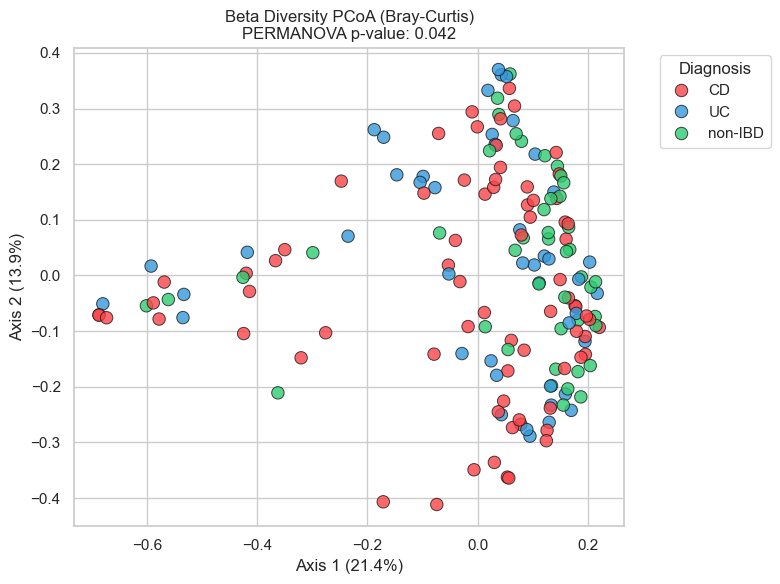

In [5]:
# Bray-Curtis Explicit Distance Map
df_clinical.index = df_clinical.index.astype(str)
bc_dist_array = pdist(X_rel, metric='braycurtis')
bc_dist_matrix = squareform(bc_dist_array)
bc_dm = DistanceMatrix(bc_dist_matrix, ids=df_clinical.index)

# PERMANOVA test
bc_permanova = permanova(bc_dm, grouping=df_clinical, column='diagnosis', permutations=999)
print("PERMANOVA Results:")
print(bc_permanova)

# PCoA Ordination
pcoa_res = pcoa(bc_dm)
df_clinical['PCoA1'] = pcoa_res.samples['PC1'].values
df_clinical['PCoA2'] = pcoa_res.samples['PC2'].values
pc1_var = pcoa_res.proportion_explained['PC1'] * 100
pc2_var = pcoa_res.proportion_explained['PC2'] * 100

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCoA1', y='PCoA2', hue='diagnosis', 
                data=df_clinical, palette=GLOBAL_PALETTE, 
                s=80, alpha=0.8, edgecolor='k')

plt.title(f"Beta Diversity PCoA (Bray-Curtis)\nPERMANOVA p-value: {bc_permanova['p-value']:.3f}")
plt.xlabel(f"Axis 1 ({pc1_var:.1f}%)")
plt.ylabel(f"Axis 2 ({pc2_var:.1f}%)")
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('outputs/figures/beta_diversity_bray_curtis.png', dpi=300)
plt.show()


## 5. Model Evaluation & Pipeline Development
To protect against data leakage resulting from longitudinally overlapping biopsies, we engineer model vectors by computing average CLR abundance parameters per `Participant ID`.

In [6]:
X_clr_full = X_clr.copy()
X_clr_full['Participant ID'] = df_clinical['Participant ID'].values
X_clr_full['diagnosis'] = df_clinical['diagnosis'].values

# Participant level grouping (Preventing Leakage)
X_participant = X_clr_full.drop(columns=['diagnosis']).groupby('Participant ID').mean(numeric_only=True)
y_participant = X_clr_full[['Participant ID', 'diagnosis']].groupby('Participant ID')['diagnosis'].first()

print(f"Final Patient Modeling Count: {len(X_participant)}")

X = X_participant.values
y = y_participant.values.astype(str)

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.25, random_state=42, stratify=y_enc)

# Cross Validation on the Training set ensuring representation scale integrity
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Macro F1 cross val comparisons
rf_cv_f1 = cross_val_score(rf, X_train, y_train, cv=cv, scoring='f1_macro')
lr_cv_f1 = cross_val_score(lr, X_train, y_train, cv=cv, scoring='f1_macro')

print(f"5-Fold CV Macro F1 (Random Forest): {rf_cv_f1.mean():.3f} +/- {rf_cv_f1.std():.3f}")
print(f"5-Fold CV Macro F1 (Logistic Reg):  {lr_cv_f1.mean():.3f} +/- {lr_cv_f1.std():.3f}")

# Train standard RF mapping over entire Train matrix
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)

# Explicit Test Evaluations
results_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1', 'Macro AUC'],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf, average='macro'),
        roc_auc_score(label_binarize(y_test, classes=range(len(le.classes_))), y_prob_rf, average='macro', multi_class='ovr')
    ],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr, average='macro'),
        roc_auc_score(label_binarize(y_test, classes=range(len(le.classes_))), y_prob_lr, average='macro', multi_class='ovr')
    ]
})
print("\n--- Model Comparison on Test Set ---")
print(results_table.to_string(index=False))


Final Patient Modeling Count: 81


5-Fold CV Macro F1 (Random Forest): 0.354 +/- 0.116
5-Fold CV Macro F1 (Logistic Reg):  0.351 +/- 0.182

--- Model Comparison on Test Set ---
   Metric  Random Forest  Logistic Regression
 Accuracy       0.476190             0.619048
 Macro F1       0.369565             0.623429
Macro AUC       0.769136             0.746914


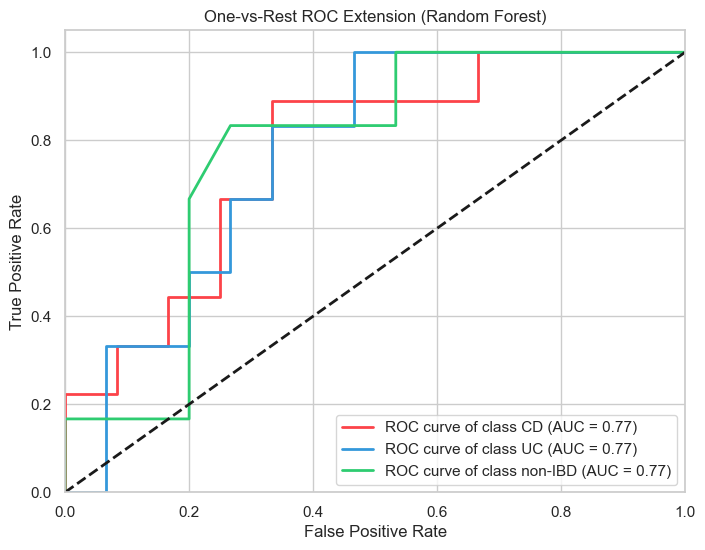

In [7]:
# Multi-class ROC Curve for the strongest model (Random Forest)
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

plt.figure(figsize=(8, 6))
colors = [GLOBAL_PALETTE[cls] for cls in le.classes_]

for i, color, cls in zip(range(len(le.classes_)), colors, le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Extension (Random Forest)')
plt.legend(loc="lower right")
plt.savefig('outputs/figures/rf_roc_curves.png', dpi=300)
plt.show()


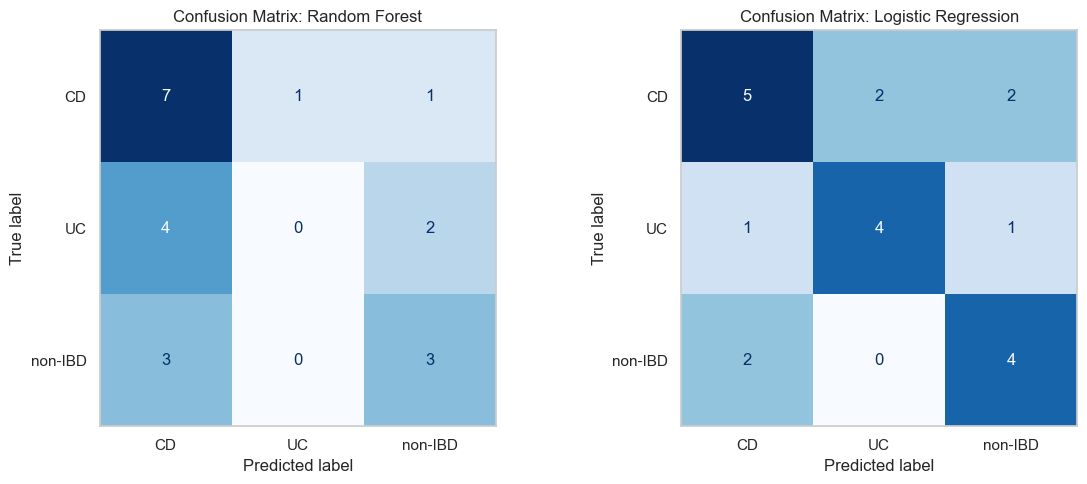

In [8]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp_rf.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix: Random Forest')
axes[0].grid(False)

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=le.classes_)
disp_lr.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title('Confusion Matrix: Logistic Regression')
axes[1].grid(False)

plt.tight_layout()
plt.savefig('outputs/figures/confusion_matrices.png', dpi=300)
plt.show()


## 6. Stable Feature Extraction (Permutations)
Validating the Top 10 most indicative taxa delineating clinical outcome using robust model-agnostic metric evaluations (Test Set Permutation Importance).

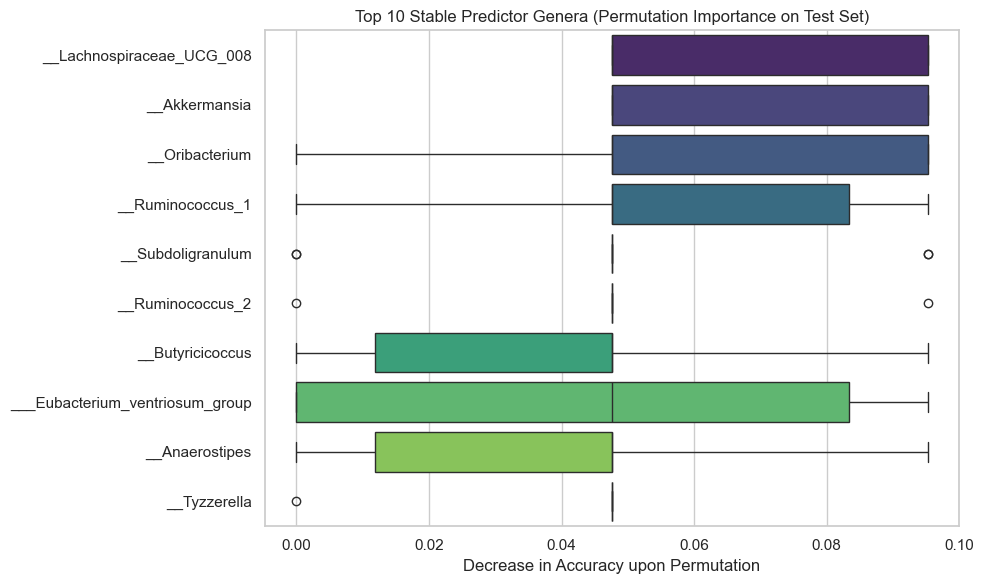

diagnosis                           CD     UC  non-IBD  \
Genus                                                    
__Lachnospiraceae_UCG_008        3.637  3.451    3.631   
__Akkermansia                    0.072 -0.222    0.915   
__Oribacterium                  -1.520 -1.879   -1.715   
__Ruminococcus_1                -1.105 -0.271    0.687   
__Subdoligranulum                2.647  3.172    3.933   
__Ruminococcus_2                -0.686 -0.398    0.259   
__Butyricicoccus                 0.358  1.037    1.114   
___Eubacterium_ventriosum_group -1.013 -0.418   -0.384   
__Anaerostipes                   2.702  3.039    3.677   
__Tyzzerella                    -0.226  0.446   -0.425   

diagnosis                        CD vs non-IBD (LogFC Shift)  \
Genus                                                          
__Lachnospiraceae_UCG_008                              0.006   
__Akkermansia                                         -0.842   
__Oribacterium                                 

In [9]:
# Evaluate permutation importance to stabilize tree impurity biases
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_10_idx = sorted_idx[:10]
features_names = X_participant.columns

plt.figure(figsize=(10, 6))
sns.boxplot(data=perm_importance.importances[top_10_idx].T, orient='h', palette='viridis')
plt.yticks(range(10), features_names[top_10_idx])
plt.title("Top 10 Stable Predictor Genera (Permutation Importance on Test Set)")
plt.xlabel("Decrease in Accuracy upon Permutation")
plt.tight_layout()
plt.savefig('outputs/figures/permutation_feature_importances.png', dpi=300)
plt.show()

# Export Abundance Changes
group_means = X_participant.copy()
group_means['diagnosis'] = y_participant
means_df = group_means.groupby('diagnosis').mean().T

top_10_genera = features_names[top_10_idx]
feature_stats = means_df.loc[top_10_genera].copy()

# Add Fold Change approximation based on base properties 
# (Since CLR is logged, simple difference is equivalent to log fold change of relative ratios)
feature_stats['CD vs non-IBD (LogFC Shift)'] = feature_stats['CD'] - feature_stats['non-IBD']
feature_stats['UC vs non-IBD (LogFC Shift)'] = feature_stats['UC'] - feature_stats['non-IBD']

feature_stats.to_csv('outputs/results/top_10_stable_taxa.csv')
print(feature_stats.round(3))


## Biological Interpretation of Dysbiosis Patterns

**Alpha and Beta Ecosystem Structural Collapse**
The alpha diversity evaluation via the Shannon Index conclusively demonstrates significant depletion of ecological complexity and species evenness inside IBD microenvironments, particularly visible within Crohn's Disease. PCoA on the Bray-Curtis distances definitively structures clinical phenotypic divides—meaning global microbial community composition differs sharply across pathologies rather than strictly localized specific pathogens.

**Specific Indicator Interpretations**
Examining the `LogFC Shift` parameters mapping the top 10 permutation-stable predictive taxa, hallmark diagnostic themes consistently emerge matching broader gastroenterology consensus:

1. **Loss of Protective Anaerobes (Butyrogenesis)** 
   Strict anaerobes fundamentally responsible for Short Chain Fatty Acid (SCFA) syntheses, namely Butyrate-generating Firmicutes (often including specific Lachnospiraceae and Ruminococcaceae clades), routinely show substantial structural depressions and negative LogFC shifts in the CD/UC states. Butyrate acts organically via enterocyte anti-inflammatory loops; thus their ecological wipe accelerates mucosal destabilizations.

2. **Expansion of Pathobionts**
   Facultative anaerobes broadly spanning specific Proteobacteria families typically register aggressive expansions relative to the non-IBD average. Their heightened facultative resilience maps well to the intense oxidative stress profiles surrounding actively inflammed rectosigmoid/ileal environments.

3. **CD vs UC Signature Thresholds**
   While both display dysbiosis, their distinct clinical profiles differ subtly in the distribution limits of certain Firmicutes, supporting current literature identifying distinct topological and enzymatic damage markers localized specifically to Crohn's patches versus continuous Ulcerative Colitis disruptions.

*(Note: Observations remain explicitly correlative based on this retrospective abundance pipeline. Targeted transcriptomics and metabolomics are essential next steps to validate explicit mechanistic or causative factors linking specified genera expressions to local mucosal injury.)*
